## learning-AI : deep learning application (61357002)
### HAR DSADS dataset을 autoencoder를 이용하여 anomaly detection

<br>

- **임규연 (lky473736)**
- 2024.10.09.에 문서 작성
- **dataset** : ```../data/DSA_features.csv```

------


## <span id='dl'><mark>DL</mark></span>
    
**DSA 데이터에서 lyingRigh과 lyingBack의 정상 데이터(각각 480개)를 사용하고, jumping 활동을 비정상 데이터로 설정**한다. 두 가지 활동(lying과 jumping)을 섞어서 데이터를 구성한 후, **lying 데이터만 사용하여 오토인코더를 학습**한다. 이후, 혼합된 테스트 데이터(lying+jumping)를 AE에 입력하여 **reconstruction error**(입력과 출력의 차이)를 계산한다. 적절한 임계값(threshold)을 설정하여 분류를 수행한 뒤, 모델의 정확도(accuracy)를 평가한다.

- **Reference**
    - https://github.com/AarnoStormborn/anomaly-detection-with-autoencoder/blob/main/anomaly-detection-with-autoencoders.ipynb
    - https://github.com/MyungKyuYi/AI-class
    - https://hoya012.github.io/blog/anomaly-detection-overview-1/
    - https://github.com/KerasKorea/KEKOxTutorial/blob/master/20_Keras%EC%9D%98%20Autoencoder%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%B4%20%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EC%9D%B4%EC%83%81%20%EA%B1%B0%EB%9E%98%20%ED%83%90%EC%A7%80%ED%95%98%EA%B8%B0.md

In [123]:
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


-----

### anomaly detection의 정의와 autoencoder를 통한 anomaly detection

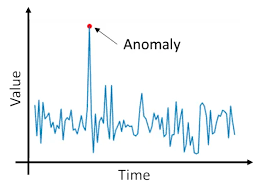

anomaly detection은 예상된 동작을 따르지 않는 데이터를 식별하는 기계 학습 기술이다. 금융, 사이버 보안, 의료 등 다양한 분야에 적용되며, 주성분 분석(PCA), K-Nearest Neighbors, Isolation Forest, Ensemble 방법 등이 사용된다. 위 figure에서 유독 값이 높은 저 point가 바로 fraud (anomaly point)이며, 저걸 감지 후 처리하여 모델의 일반화 성능을 끌어올리는 것이 요즘에는 매우 중요한 과제가 되겠다. 그 이유는, 특정 data가 어떤 기준에 포함이 되는가, 포함이 되지 않는가를 논하는 상황은 어느 곳에서나 발생될 수 있다. 예를 들자면 CCTV를 이용한 수상인물 감지, 범인 색출 등 처럼 말이다.

그러면 도대체 autoencoder로 어떻게 anomaly detection을 할 수 있는가? autoencoder는 정상적이고 비변칙적인 데이터 세트로 훈련한 다음, 학습된 패턴과 일치하지 않는 새 데이터의 변칙을 식별하는 데 사용될 수 있을 것이다. 이상 현상은 종종 드문 사건이고 훈련 데이터에서 잘 표현되지 않을 수 있으므로 이상 탐지 모델을 평가하는 것은 어려울 것이다. autoencoder를 이용하여 **정상적인 정보를 encoder를 통해 압축시키게 하면서 학습시키고, 이를 이상 탐지 실전에 적용하는 것이다.** 정상적인 정보를 위해 autoencoder가 작동하였을 때, 만약 이상한 정보가 입력되었을 경우엔 이것이 **변칙 사항**으로 인식될 것이다.

-----


### 1. 탐색적 데이터 분석 및 데이터 전처리 수행
- 데이터 시각화 및 필요한 정보를 얻어낸다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.

In [125]:
# 데이터 로드

df = pd.read_csv('../../data/DSA_features.csv')
# df = pd.read_csv('../dataset/ae_data.csv')

df.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [126]:
# 데이터의 정보 및 기초통계량 확인

df.info() 
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Columns: 272 entries, T_xacc_mean to people
dtypes: float64(270), object(2)
memory usage: 18.9+ MB


,count,mean,std,min,25%,50%,75%,max
T_xacc_mean,9120.0,7.765766,3.758022,-1.157566e+01,8.374161,9.186328,9.515573,10.713139
T_xacc_max,9120.0,14.625536,11.823448,-4.758700e+00,9.523200,12.549500,15.843250,93.694000
T_xacc_min,9120.0,3.602974,5.622855,-9.971500e+01,0.000000,5.757900,7.649075,9.749000
T_xacc_var,9120.0,17.807013,45.188787,1.353291e-04,0.036855,2.241468,6.680571,392.898630
T_xacc_std,9120.0,2.454290,3.432895,1.163310e-02,0.191977,1.497153,2.584680,19.821671
...,...,...,...,...,...,...,...,...
LL_zmag_max,9120.0,0.169687,0.360190,-9.108300e-01,-0.035821,0.210825,0.422270,1.042600
LL_zmag_min,9120.0,-0.052866,0.359712,-1.126000e+00,-0.326125,-0.040447,0.206933,0.999440
LL_zmag_var,9120.0,0.007625,0.019034,2.960874e-07,0.000223,0.001814,0.006928,0.279020
LL_zmag_std,9120.0,0.059342,0.064059,5.441392e-04,0.014925,0.042586,0.083234,0.528223


In [127]:
# 결측치 확인

'''
    결측치 없음을 확인 가능
'''

print (df.isnull().sum()) 
print (any(df.isnull().sum())) # False로 나왔으니 결측치가 없는 것임

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64
False


In [128]:
# class 종류 확인

print (f"class 종류 :  {np.unique(df['activity'])}")

class 종류 :  ['ascendingStairs' 'basketBall' 'crossTrainer' 'cyclingHorizontal'
 'cyclingVertical' 'decendingStairs' 'jumping' 'lyingBack' 'lyingRigh'
 'movingInElevator' 'rowing' 'runningTreadmill' 'sitting' 'standing'
 'standingInElevatorStill' 'stepper' 'walkingLot' 'walkingTreadmillFlat'
 'walkingTreadmillIncline']


In [129]:
# 3가지 행동추출 (lyingRigh, lyingBack, jumping)

df = df.loc[df['activity'].isin(['lyingRigh', 'lyingBack', 'jumping'])]
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,9.298029,32.4980,-6.0782,134.634624,11.603216,0.570723,-2.592341,1.73230,-12.91800,9.207424,...,0.030501,0.334449,0.625187,0.69130,0.57187,9.188517e-04,0.030313,0.274486,jumping,p8
8636,8.738784,34.0480,-6.7822,145.225186,12.050941,0.760224,-2.417799,1.19030,-10.90200,9.233904,...,0.031573,0.396417,0.624749,0.69356,0.57040,9.632708e-04,0.031037,0.433661,jumping,p8
8637,9.404261,34.8670,-5.3331,130.142955,11.408022,0.560963,-2.408945,0.81347,-8.21750,6.635468,...,0.030322,0.524964,0.631822,0.69012,0.58197,8.933477e-04,0.029889,0.335023,jumping,p8
8638,9.139112,32.5060,-6.8835,135.812815,11.653876,0.589304,-2.359531,1.32350,-9.57930,7.510565,...,0.024060,0.301200,0.624196,0.68856,0.57362,1.025797e-03,0.032028,0.272121,jumping,p8


activity
lyingBack    480
lyingRigh    480
jumping      480
Name: count, dtype: int64


<Axes: xlabel='activity', ylabel='count'>

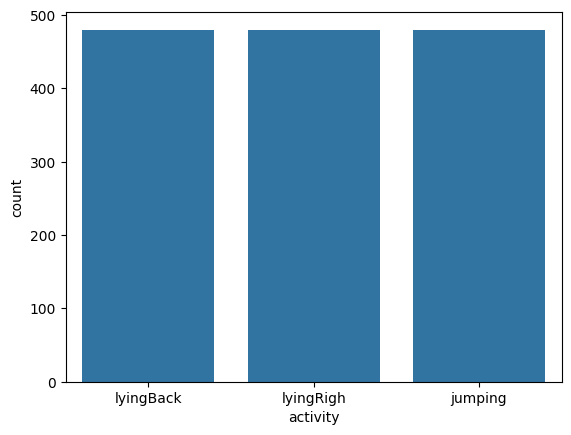

In [130]:
# target countplot

print (df['activity'].value_counts())
sns.countplot(x='activity', data=df)

In [131]:
# df에서 people 열 제거

df = df.drop('people', axis=1)

In [132]:
# what 열을 수정
# jumping이면 abnormal, lyingRigh이나 lyingBack은 normal

df['what'] = df['activity'].map({
    'jumping': 'abnormal',
    'lyingRigh': 'normal',
    'lyingBack': 'normal'
})

df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,what
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.41744,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,normal
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.40372,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,normal
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.42616,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,normal
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.30877,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,normal
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.38900,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,9.298029,32.4980,-6.0782,134.634624,11.603216,0.570723,-2.592341,1.73230,-12.91800,9.207424,...,0.030501,0.334449,0.625187,0.69130,0.57187,9.188517e-04,0.030313,0.274486,jumping,abnormal
8636,8.738784,34.0480,-6.7822,145.225186,12.050941,0.760224,-2.417799,1.19030,-10.90200,9.233904,...,0.031573,0.396417,0.624749,0.69356,0.57040,9.632708e-04,0.031037,0.433661,jumping,abnormal
8637,9.404261,34.8670,-5.3331,130.142955,11.408022,0.560963,-2.408945,0.81347,-8.21750,6.635468,...,0.030322,0.524964,0.631822,0.69012,0.58197,8.933477e-04,0.029889,0.335023,jumping,abnormal
8638,9.139112,32.5060,-6.8835,135.812815,11.653876,0.589304,-2.359531,1.32350,-9.57930,7.510565,...,0.024060,0.301200,0.624196,0.68856,0.57362,1.025797e-03,0.032028,0.272121,jumping,abnormal


In [133]:
# df에서 activity 열 제거

df = df.drop('activity', axis=1)

In [134]:
# normal과 abnormal dataset을 구성, train set, test set 구성

abnormal = df[df.what == 'abnormal'] 
normal = df[df.what == 'normal']
 
train = normal.copy() # train data (normal만 학습시킴)
test = pd.concat([normal, abnormal])  # 합치기

train.shape, test.shape

((960, 271), (1440, 271))

<Axes: xlabel='what', ylabel='count'>

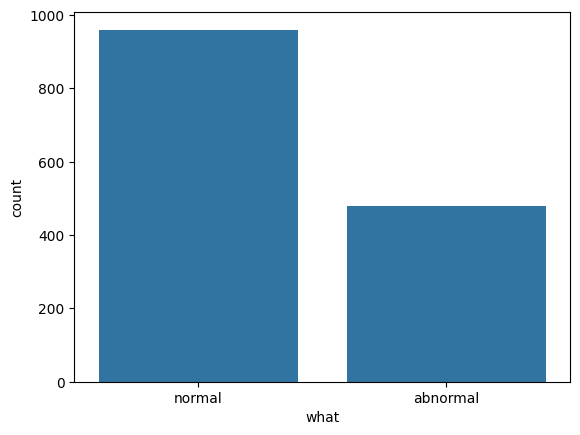

In [135]:
# normal과 abnormal 갯수 countplot

sns.countplot(x='what', data=df)

In [136]:
# normal을 0, abnormal을 1로 만들기

# train 데이터프레임에서 'what' 열 수정
train['what'] = 0 # 어차피 모든 열이 다 normal임

print (any(train['what'] == 1)) # false가 나오는게 정상임

# test 데이터프레임에서 'what' 열 수정
test['what'] = test['what'].map({
    'normal': 0,
    'abnormal': 1
})

print (train['what'].unique())
print (test['what'].unique())

False
[0]
[0 1]


In [137]:
# input, target split

y_train, X_train = train['what'], train.drop('what', axis=1)
y_test, X_test = test['what'], test.drop('what', axis=1)

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (y_train.unique(), y_test.unique())

(960, 270) (960,) (1440, 270) (1440,)
[0] [0 1]


In [138]:
# z-score normalization

from sklearn.preprocessing import StandardScaler

normalizier = StandardScaler()
X_train_scaled = normalizier.fit_transform(X_train)
X_test_scaled = normalizier.transform(X_test)

-----


### 2. autoencoder를 통한 anomaly detection

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         8,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 270)            │         4,590 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,166 (55.34 KB)

 Trainable params: 14,166 (55.34 KB)

 Non-trainable params: 0 (0.00 B)

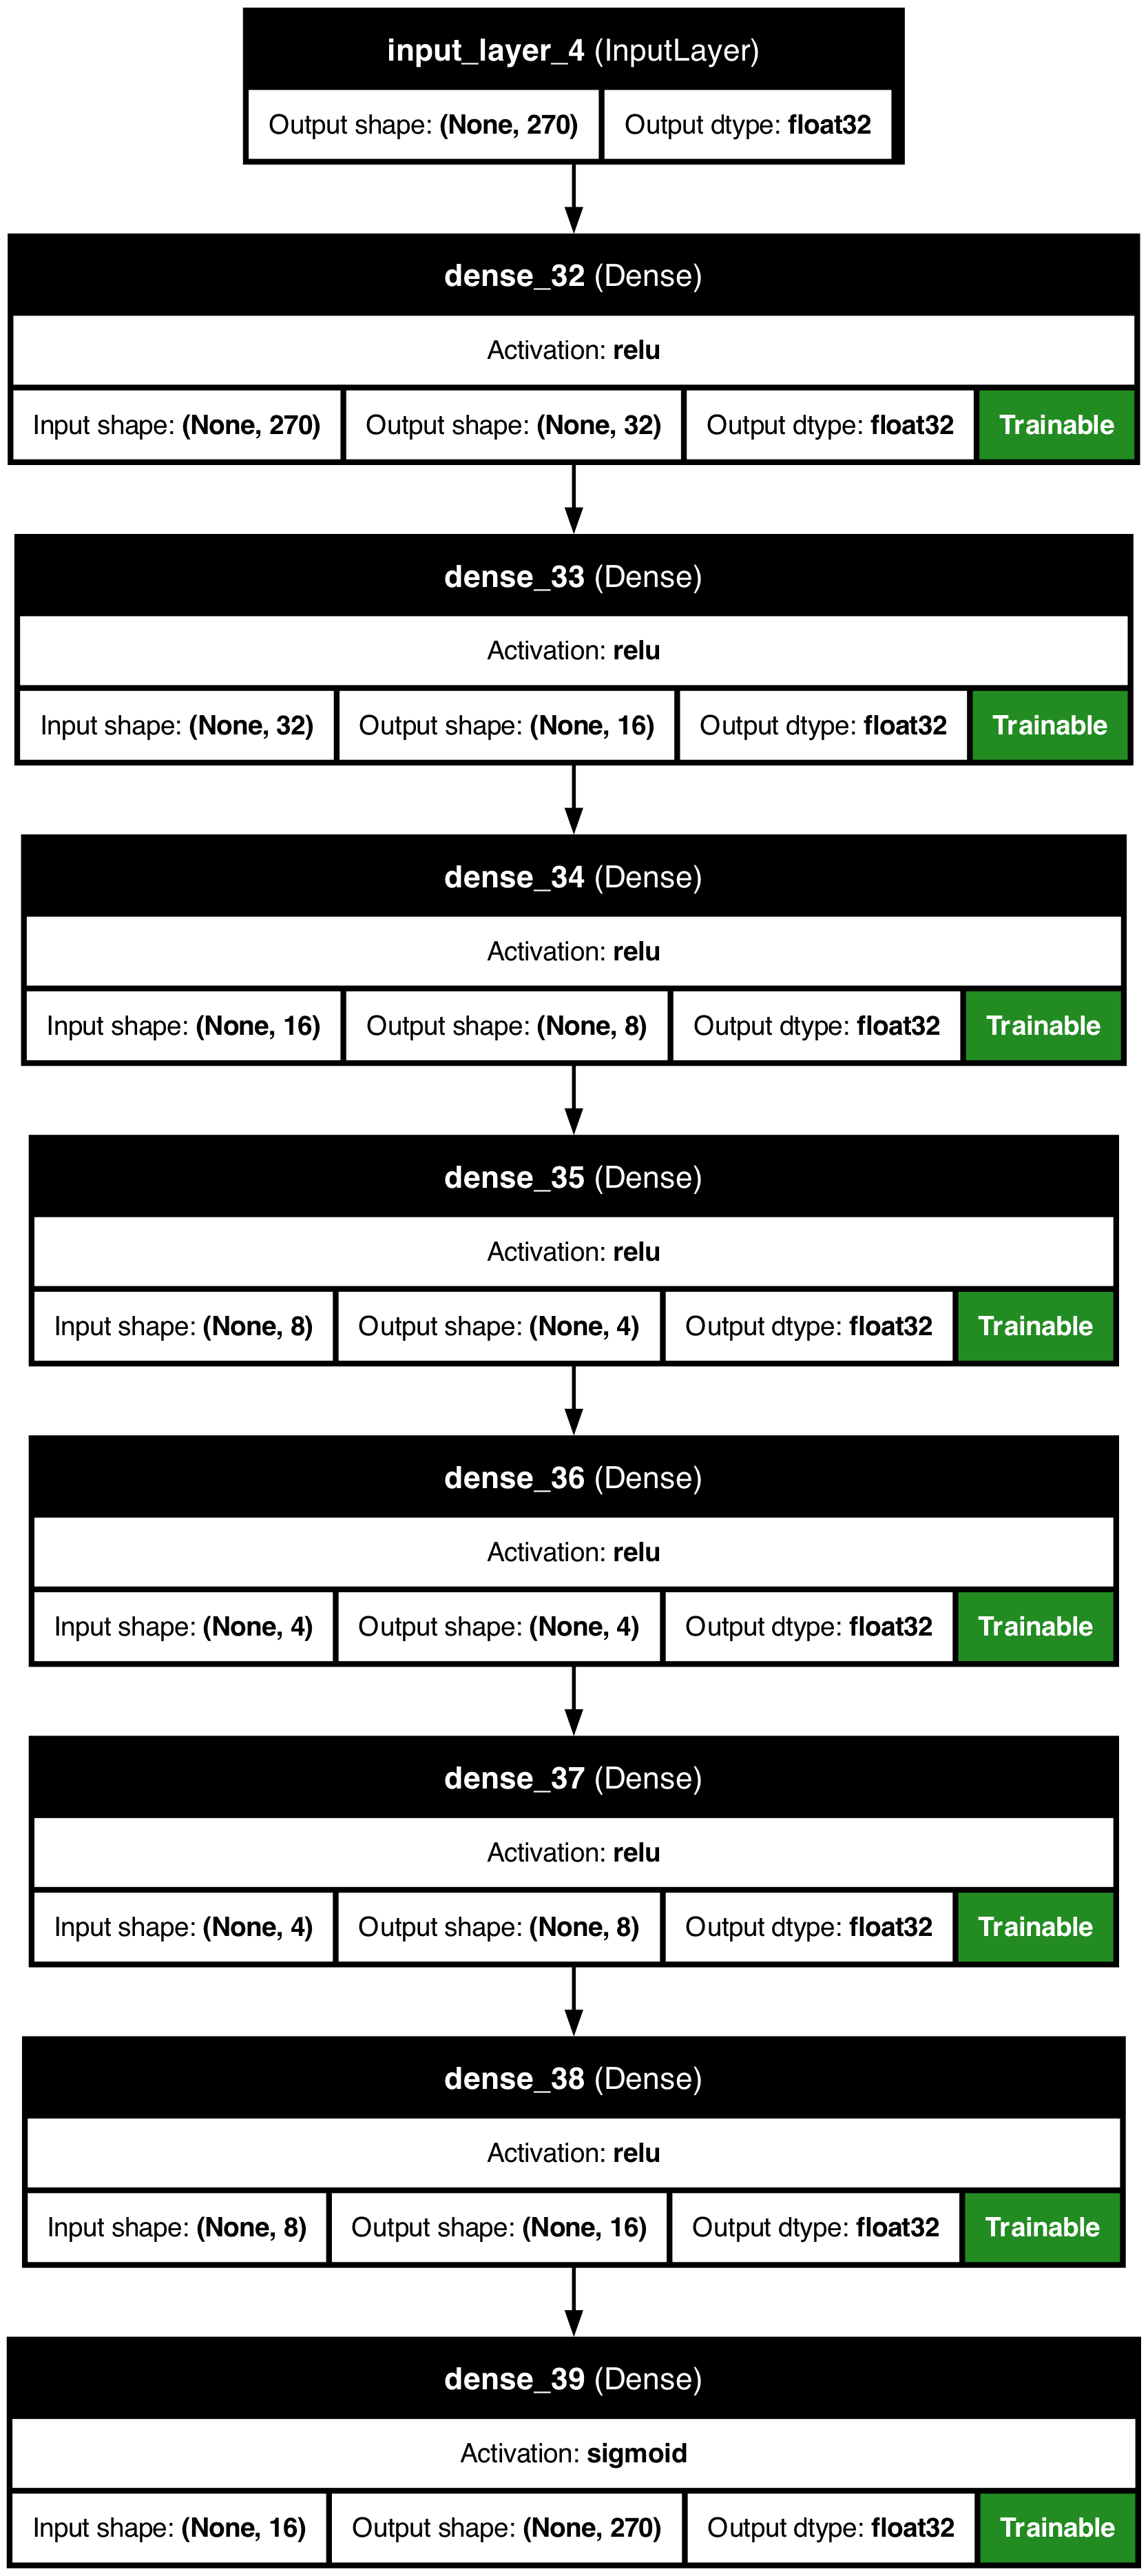

In [139]:
# modeling

input_dim = X_train.shape[1]  # feature의 갯수임
encoding_dim = 32

input_layer = Input(shape=(input_dim,))

# encoding 단계
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)
encoded = Dense(encoding_dim // 8, activation='relu')(encoded)

# decoding 단계
decoded = Dense(encoding_dim // 8, activation='relu')(encoded)
decoded = Dense(encoding_dim // 4, activation='relu')(decoded)
decoded = Dense(encoding_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, show_dtype=True,
                         show_layer_activations=True,
                         show_layer_names=True,
                         show_shapes=True,
                         show_trainable=True)

In [140]:
# compile

from keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [141]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = autoencoder.fit(X_train_scaled, X_train_scaled,  # 자기 자신을 training (비지도 학습)
                          epochs=50, 
                          batch_size=128, 
                          shuffle=True, 
                          callbacks=[early_stopping_cb],
                          validation_split = 0.1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.1883 - val_loss: 0.8381
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1031 - val_loss: 0.8345
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1508 - val_loss: 0.8272
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5134 - val_loss: 0.8139
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3316 - val_loss: 0.7906
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1486 - val_loss: 0.7556
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0483 - val_loss: 0.7117
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3439 - val_loss: 0.6715
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3145 - val_loss: 0.6458
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0099 - val_loss: 0.6309
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3253 - val_loss: 0.6191
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0556 - val_loss: 0.6085
Epoch 13/50


{'loss': [1.294417381286621, 1.2910820245742798, 1.2857390642166138, 1.2755831480026245, 1.2567945718765259, 1.2254278659820557, 1.1766839027404785, 1.1178936958312988, 1.061133861541748, 1.020886778831482, 0.9980406761169434, 0.9836117625236511, 0.9746242165565491, 0.9701660871505737, 0.9660026431083679, 0.9642464518547058, 0.9628244042396545, 0.9615440964698792, 0.9602572917938232, 0.9589288234710693, 0.9577595591545105, 0.9569186568260193, 0.956224799156189, 0.9554535150527954, 0.9545279741287231, 0.9536150693893433, 0.9526334404945374, 0.9516194462776184], 'val_loss': [0.8381498456001282, 0.8345246315002441, 0.8272325396537781, 0.8138524889945984, 0.7905573844909668, 0.7555562853813171, 0.7117083072662354, 0.6715129017829895, 0.645846426486969, 0.6308557391166687, 0.6191406846046448, 0.6084713935852051, 0.6010922789573669, 0.5989932417869568, 0.5990853905677795, 0.5985212326049805, 0.5949750542640686, 0.5900614857673645, 0.5843989849090576, 0.5783328413963318, 0.5784648060798645, 0

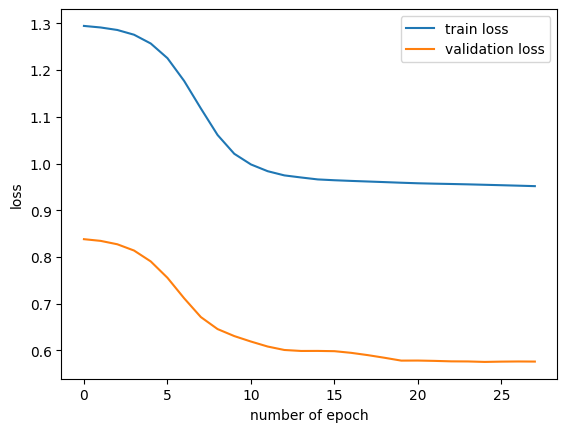

'\n    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.\n'

In [142]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

'''
    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.
'''

In [143]:
# reconstruction error 

predictions = autoencoder.predict(X_test_scaled) 
reconstruction_error = np.mean(np.square(X_test_scaled - predictions), axis=1) # mse

error_df = pd.DataFrame({
    'reconstruction_error': reconstruction_error,
    'true_class': y_test
})

'''
    reconstruction error가 높다 -> fraud일 가능성이 매우 높아지는 것 
    (실제 정상인 데이터를 가지고 모델을 학습시켰으니 이상한 값에 대하여 loss가 많을 것)
'''

error_summary = error_df.describe()
error_summary

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


,reconstruction_error,true_class
count,1.440000e+03,1440.000000
mean,1.003572e+06,0.333333
std,2.202082e+06,0.471568
min,1.628392e-01,0.000000
25%,3.675292e-01,0.000000
50%,5.259182e-01,0.000000
75%,6.452588e+05,1.000000
max,2.699335e+07,1.000000


In [144]:
error_df

,reconstruction_error,true_class
960,2.353059e-01,0
961,2.716529e-01,0
962,2.183851e-01,0
963,2.767638e-01,0
964,2.482528e-01,0
...,...,...
8635,3.684836e+06,1
8636,3.166965e+06,1
8637,3.095482e+06,1
8638,2.846192e+06,1


In [145]:
# 임계값 설정

mean_error = error_df['reconstruction_error'].mean()
std_error = error_df['reconstruction_error'].std()

k = 2
threshold = (mean_error + k * std_error) / 100000

print (threshold)

54.07735361397628


위 threshold는 일종의 cutline으로, 이 너머에 있는 data를 이상치로 판단하는 것으로 해석할 수 있다. 보통은 아래와 같은 공식을 사용하여 threshold를 설정한다.

$$
\text{threshold} = \text{mean} + k \times \text{std}
$$

- 여기서 $k$는 선택하는 상수로, 일반적으로 2 또는 3의 값을 사용한다. $k$의 값은 탐지의 민감도에 영향을 미친다.

만약 **$k = 2$** 이라면 약 95%의 정상 데이터 포인트를 포함하는 임계값이다. 즉, 평균에서 두 표준편차 내에 있는 데이터는 정상으로 간주되며, 두 표준편차를 초과하는 재구성 오류는 비정상으로 판단된다.

**$k = 3$** 이라면 약 99.7%의 정상 데이터 포인트를 포함하는 더 보수적인 접근 방식이다. 이 경우 비정상 데이터가 많을 때, 일부 정상 데이터도 잘못 탐지될 수 있다.


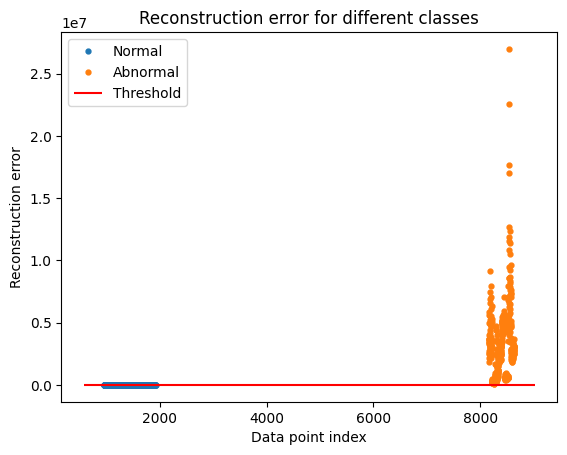

In [146]:
# reconstruction error visualization

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       480

    accuracy                           1.00      1440
   macro avg       1.00      1.00      1.00      1440
weighted avg       1.00      1.00      1.00      1440



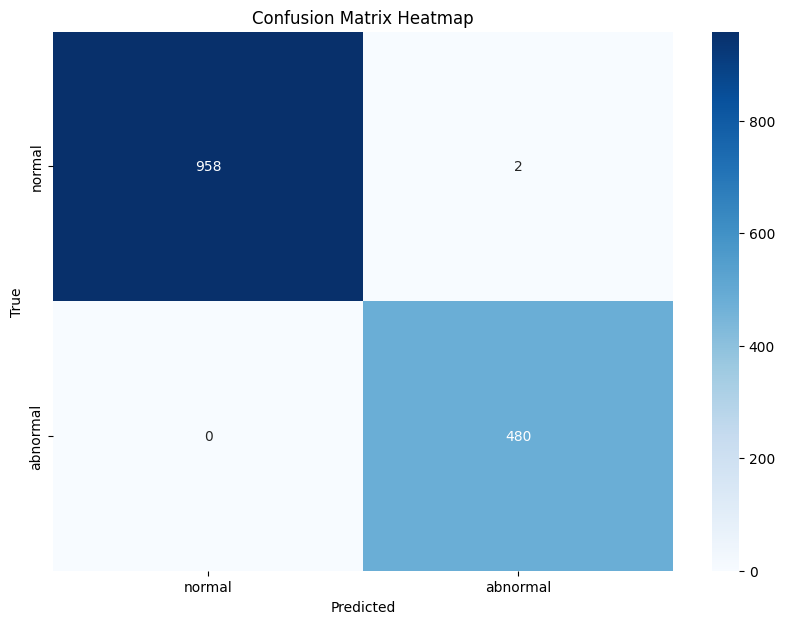

In [148]:
# classification report, heatmap

from sklearn.metrics import confusion_matrix, classification_report

error_df['predicted_class'] = (error_df['reconstruction_error'] > threshold).astype(int)
print(classification_report(error_df['true_class'], error_df['predicted_class']))

cm = confusion_matrix(error_df['true_class'], error_df['predicted_class'])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'abnormal'], 
            yticklabels=['normal', 'abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()
